# Imports

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import (resnet18, ResNet18_Weights, resnet50, ResNet50_Weights, resnet152, ResNet152_Weights,
                              efficientnet_b0, EfficientNet_B0_Weights,
                              vgg16, VGG16_Weights)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import time
import random
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
#torch.cuda.manual_seed_all(RANDOM_SEED)

# Configs

In [ ]:
TRAIN_IMGS_PATH = '/content/drive/MyDrive/GBCUD/dataset/train'
TEST_IMGS_PATH = '/content/drive/MyDrive/GBCUD/dataset/test'
SAVE_MODEL_DIR = '/content/drive/MyDrive/GBCUD/'

In [ ]:
RANDOM_SEED = 42
LABEL_MAPPING = {'0_normal': 0, '1_benign': 1, '2_malignant': 2}
CLASS_NAMES = list(LABEL_MAPPING.keys())

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1      # 1 bag
NUM_EPOCHS = 50
PATIENCE = 10
NUM_CLASSES = len(LABEL_MAPPING)
CLASS_WEIGHTS = [0.8, 0.6, 3.0]

# FEATURE_DIM_L = 512
# ATTENTION_DIM_D = 256
# ATTENTION_HEADS_K = 1
DROPOUT_RATE = 0.5

IMG_RESIZE = (256, 256) # Initial resize size
IMG_CROP_SIZE = (224, 224) # Final input size to model

# Define normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Helper functions

In [ ]:
#plots training and validation loss and accuracy graphs
def plot_training_history(train_losses, train_acc, val_losses, val_acc):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # loss graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Model Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#compute and plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Data)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Preprocessing and Data augmentation

In [ ]:
def get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE):
  def crop_top_half(image, **kwargs):
      h, w = image.shape[:2]
      y_min = int(0.20 * h)
      y_max = int(0.90 * h)
      return image[y_min:y_max, :]

  return A.Compose([
      A.Resize(height=resize_dim[0], width=resize_dim[1]),
      A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, fill=0),
      A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
      A.ISONoise(intensity=(0.1, 0.4), p=0.3),
      # A.RandomShadow(p=0.3),
      A.Lambda(image=crop_top_half),
      # A.CenterCrop(height=crop_dim[0], width=crop_dim[1]),
      A.HorizontalFlip(p=0.5),
      A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ToTensorV2()
  ])

def get_eval_transforms(img_dim=IMG_CROP_SIZE):
    return A.Compose([
        A.Resize(height=img_dim[0], width=img_dim[1]),
        A.CenterCrop(height=img_dim[0], width=img_dim[1]),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

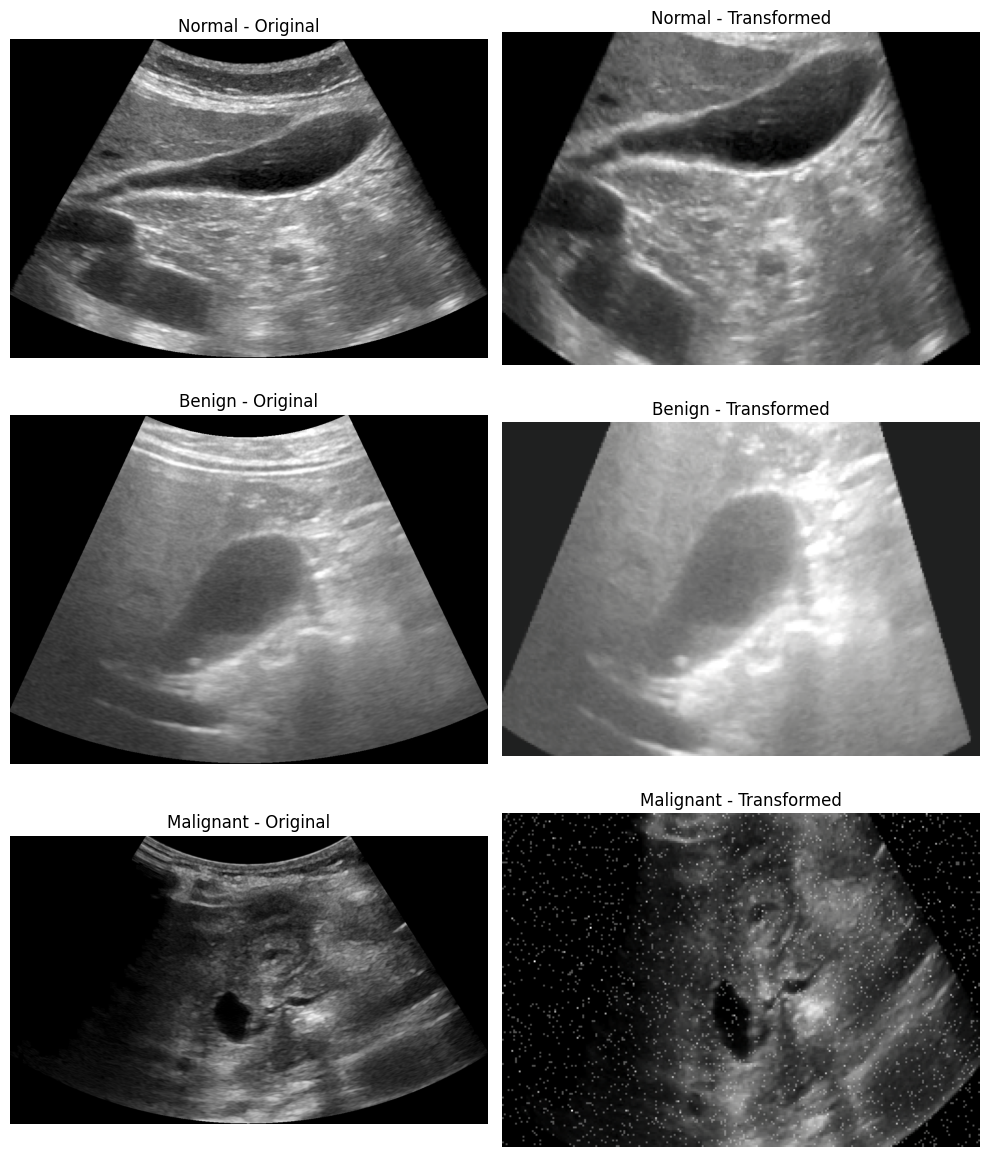

In [ ]:
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.transforms.functional import to_pil_image
import numpy as np


# Load and transform image
def visualize_transformed_image(image_path, transform):
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    transformed = transform(image=original_img)
    transformed_img = transformed["image"]

    # De-normalize for visualization
    img_vis = transformed_img.clone()
    img_vis = img_vis * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_vis = img_vis + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img_vis = torch.clamp(img_vis, 0, 1)

    return original_img, to_pil_image(img_vis)

# Example usage:
sample_paths = {
    "Normal": "/content/drive/MyDrive/GBCUD/dataset/train/0_normal/im00007.jpg",
    "Benign": "/content/drive/MyDrive/GBCUD/dataset/train/1_benign/im00001.jpg",
    "Malignant": "/content/drive/MyDrive/GBCUD/dataset/train/2_malignant/im00017.jpg"
}

transform = get_train_transforms()

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for idx, (label, img_path) in enumerate(sample_paths.items()):
    original, transformed = visualize_transformed_image(img_path, transform)

    axes[idx, 0].imshow(original)
    axes[idx, 0].set_title(f"{label} - Original")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(transformed)
    axes[idx, 1].set_title(f"{label} - Transformed")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()


# Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class ImageBagDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Root directory with subfolders for each class.
            transform (callable): Albumentations transform to apply to each image.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []
        self.labels = []

        class_folders = sorted(os.listdir(image_dir))
        for folder_name in class_folders:
            label = int(folder_name.split('_')[0])
            folder_path = os.path.join(image_dir, folder_name)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.samples.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        image_name = os.path.basename(img_path)

        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label, image_name

# Model build

In [ ]:
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes=3, backbone_name='resnet18', pretrained=True,
                 feature_dim=512, attention_dim=128, attention_heads=1, dropout=0.5):
        super().__init__()
        self.L = feature_dim  # 512 node fully connected layer
        self.D = attention_dim  # 128 node attention layer
        self.K = attention_heads
        self.num_classes = num_classes

        # backbone
        self.feature_extractor, backbone_out_dim = self._get_backbone(backbone_name, pretrained)

        # Adaptive pooling and feature embedding
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_embedder = nn.Sequential(
            nn.Linear(backbone_out_dim, self.L),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Linear(self.L * self.K, self.num_classes)

    def _get_backbone(self, name, pretrained):
        weights = 'DEFAULT' if pretrained else None

        if name == "resnet18":
            model = resnet18(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 512
        elif name == "resnet50":
            model = resnet50(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 2048
        elif name == "resnet152":
            model = resnet152(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 2048
        elif name == "efficientnet_b0":
            model = efficientnet_b0(weights=weights)
            return model.features, 1280
        elif name == "vgg16":
            model = vgg16(weights=weights)
            return nn.Sequential(*list(model.features.children())[:-1]), 512
        else:
            raise ValueError(f"Error with backbone {name}")

    def forward(self, x):
        # x: [1, C, H, W]
        features = self.feature_extractor(x)
        features = self.pool(features).view(1, -1)
        embedded = self.feature_embedder(features)

        A = self.attention(embedded)
        A = F.softmax(A, dim=0)
        M = A * embedded

        logits = self.classifier(M.view(1, -1))
        probs = F.softmax(logits, dim=1)
        return logits, probs, A

    def calculate_objective(self, x_batch, y_batch, criterion):
        logits, _, _ = self.forward(x_batch)
        return criterion(logits, y_batch)

    def calculate_prediction_accuracy(self, x_batch, y_batch):
        logits, _, _ = self.forward(x_batch)
        preds = torch.argmax(logits, dim=1)
        correct = preds.eq(y_batch).sum().item()
        total = y_batch.size(0)
        return preds, correct / total, correct, total

    def get_attention_map(self, bag_tensor):
        self.eval()
        with torch.no_grad():
            if image_tensor.ndim != 4:
                raise ValueError(f"Wrong input shape: {image_tensor.shape}")
            image_tensor = image_tensor.to(next(self.parameters()).device)

            features = self.feature_extractor(image_tensor)
            features = self.pool(features).view(1, -1)
            embedded = self.feature_embedder(features)
            A = self.attention(embedded)
            A = F.softmax(A, dim=0)
            return A.squeeze().cpu().numpy()

In [ ]:
#vanilla attention
model = AttentionMILModel(num_classes=3, backbone_name='resnet18')
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
#vanilla attention
model = AttentionMILModel(num_classes=3, backbone_name='vgg16')
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224)
logits, probs, att = model(dummy_input)
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Train and Evaluate

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, save_dir, model_name, patience=PATIENCE):

  os.makedirs(save_dir, exist_ok=True)
  save_path = os.path.join(save_dir, model_name)

  best_val_loss = float('inf')
  epochs_no_improve = 0
  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


  model.to(device)
  print(f"Start Training model")

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for bags, labels, _ in train_loader:
      bags = bags[0].unsqueeze(0).to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      logits, probs, _ = model(bags)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      predictions = torch.argmax(probs, dim=1)
      train_correct += (predictions == labels).sum().item()
      train_total += labels.size(0)

    epoch_train_loss = running_loss / train_total
    epoch_train_acc = train_correct / train_total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # validation
    val_metrics, _, _ = evaluate_model(model, val_loader, criterion, device)
    epoch_val_loss = val_metrics['loss']
    epoch_val_acc = val_metrics['accuracy']
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    # early stopping
    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      epochs_no_improve = 0
      torch.save(model.state_dict(), save_path)
      print(f"Model saved to {save_path}")
    else:
      epochs_no_improve += 1
      print(f"Validation loss did not improve for {epochs_no_improve} epochs :(")
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

  print("\nTraining donee.")

  model.load_state_dict(torch.load(save_path))
  print("Loaded model weights.")

  return model, history

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_predictions = []
    all_true_labels = []
    all_probs = []

    with torch.no_grad():
        for bags, labels, _ in dataloader:
            image = bags[0].unsqueeze(0).to(device)
            labels = labels.to(device)

            outputs, probabilities, _ = model(image)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = torch.argmax(probabilities, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    precision = precision_score(all_true_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_true_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)
    auc = roc_auc_score(all_true_labels, all_probs, average='macro', multi_class='ovr')

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    return metrics, all_true_labels, all_predictions

# Experiments

In [ ]:
BACKBONE_NAME = "resnet18"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with resnet18 backbone
Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.1102, Acc: 0.3488 | Val Loss: 1.0967, Acc: 0.3436
Model saved to /content/drive/MyDrive/GBCUD/sbam1.pth
Epoch 2/50 | Train Loss: 1.1050, Acc: 0.3377 | Val Loss: 1.1120, Acc: 0.2115
Validation loss did not improve for 1 epochs :(
Epoch 3/50 | Train Loss: 1.1035, Acc: 0.3422 | Val Loss: 1.1014, Acc: 0.3084
Validation loss did not improve for 2 epochs :(
Epoch 4/50 | Train Loss: 1.1004, Acc: 0.3411 | Val Loss: 1.0994, Acc: 0.3656
Validation loss did not improve for 3 epochs :(
Epoch 5/50 | Train Loss: 1.0852, Acc: 0.3830 | Val Loss: 1.1029, Acc: 0.3833
Validation loss did not improve for 4 epochs :(
Epoch 6/50 | Train Loss: 1.0529, Acc: 0.4558 | Val Loss: 1.1241, Acc: 0.2467
Vali

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


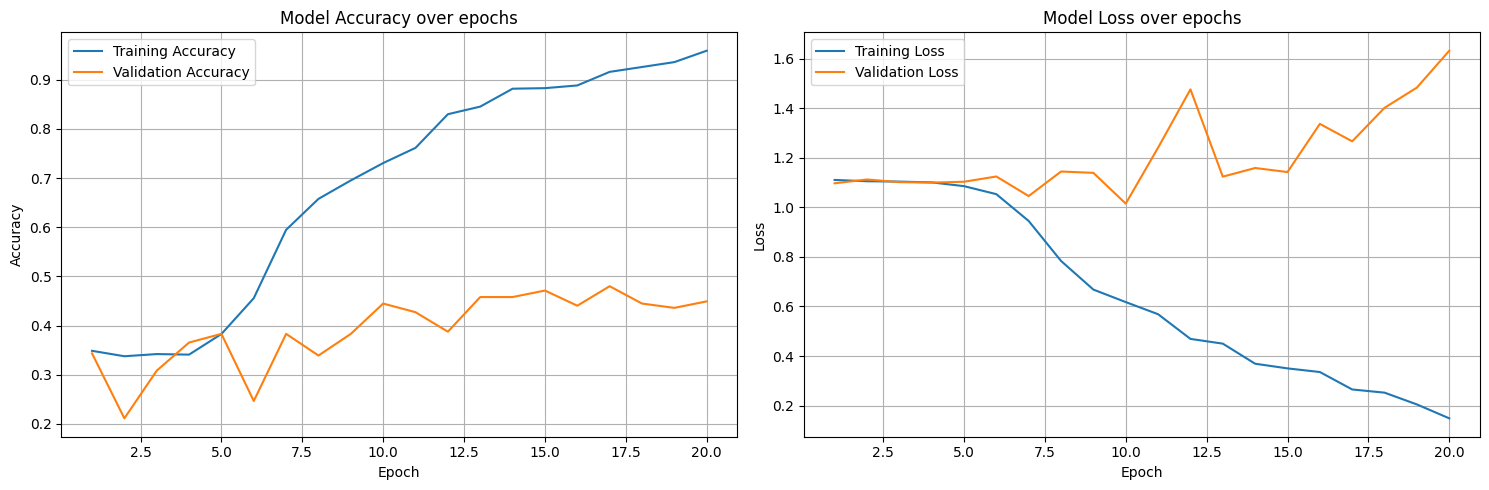

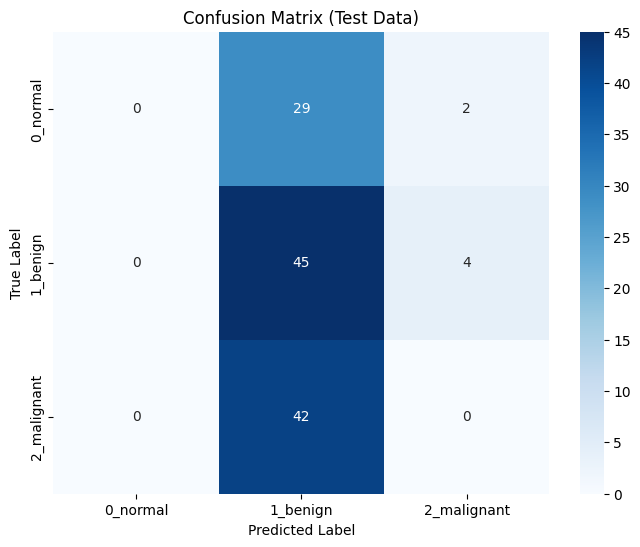


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam1.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet50"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with resnet50 backbone


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0982, Acc: 0.3377 | Val Loss: 1.0987, Acc: 0.3568
Model saved to /content/drive/MyDrive/GBCUD/sbam2.pth
Epoch 2/50 | Train Loss: 1.0951, Acc: 0.3709 | Val Loss: 1.0949, Acc: 0.4141
Model saved to /content/drive/MyDrive/GBCUD/sbam2.pth
Epoch 3/50 | Train Loss: 1.0889, Acc: 0.3874 | Val Loss: 1.0966, Acc: 0.4009
Validation loss did not improve for 1 epochs :(
Epoch 4/50 | Train Loss: 1.0748, Acc: 0.3720 | Val Loss: 1.0916, Acc: 0.4141
Model saved to /content/drive/MyDrive/GBCUD/sbam2.pth
Epoch 5/50 | Train Loss: 1.0199, Acc: 0.4360 | Val Loss: 1.0691, Acc: 0.3877
Model saved to /content/drive/MyDrive/GBCUD/sbam2.pth
Epoch 6/50 | Train Loss: 0.8893, Acc: 0.5552 | Val Loss: 1.0214, Acc: 0.4009
Model saved to /content/drive/MyDrive/GBCUD/sbam2.pth
Epoch 7/50 | Train Loss: 0.8098, Acc: 0.6038 | Val Loss: 0.9846, Acc: 0.4097
Model saved to /content/drive/MyDrive/GBCUD/sbam2.pth
Epoch 8/50 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


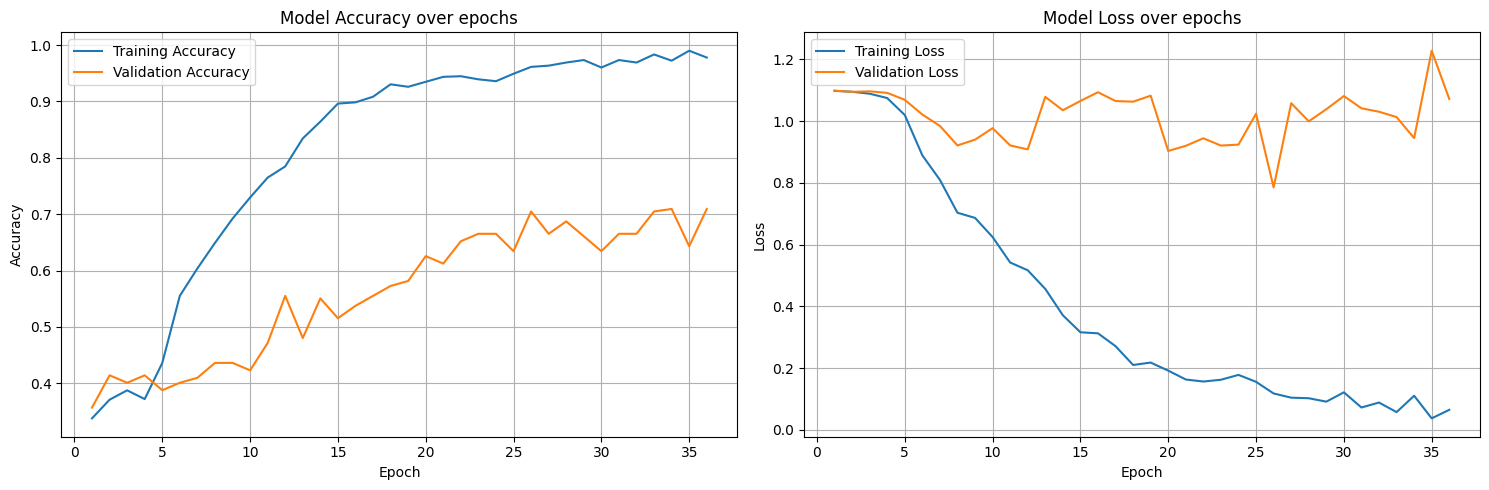

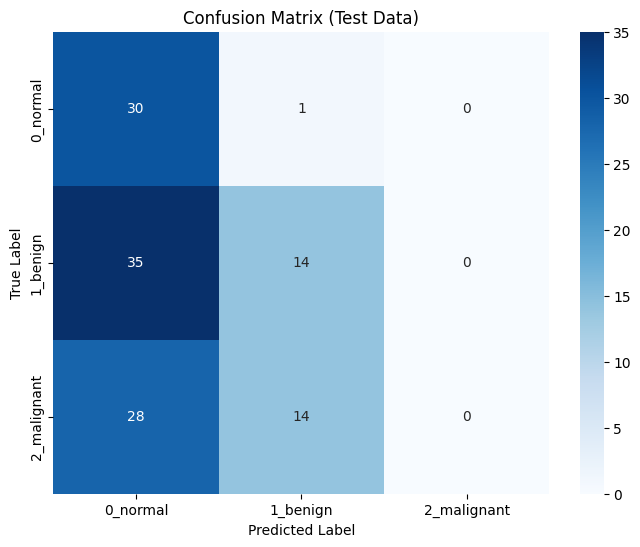


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam2.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet152"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with resnet152 backbone


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 185MB/s]


Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0981, Acc: 0.3521 | Val Loss: 1.0903, Acc: 0.4537
Model saved to /content/drive/MyDrive/GBCUD/sbam3.pth
Epoch 2/50 | Train Loss: 1.0958, Acc: 0.3587 | Val Loss: 1.1224, Acc: 0.2467
Validation loss did not improve for 1 epochs :(
Epoch 3/50 | Train Loss: 1.0817, Acc: 0.4338 | Val Loss: 1.2118, Acc: 0.3656
Validation loss did not improve for 2 epochs :(
Epoch 4/50 | Train Loss: 0.8961, Acc: 0.6280 | Val Loss: 1.0346, Acc: 0.4714
Model saved to /content/drive/MyDrive/GBCUD/sbam3.pth
Epoch 5/50 | Train Loss: 0.5772, Acc: 0.7671 | Val Loss: 1.5401, Acc: 0.4890
Validation loss did not improve for 1 epochs :(
Epoch 6/50 | Train Loss: 0.4170, Acc: 0.8521 | Val Loss: 2.2724, Acc: 0.5198
Validation loss did not improve for 2 epochs :(
Epoch 7/50 | Train Loss: 0.3535, Acc: 0.8797 | Val Loss: 6.2537, Acc: 0.3700
Validation loss did not improve for 3 epochs :(
Epoch 8/50 | Train Loss: 0.2616, Ac

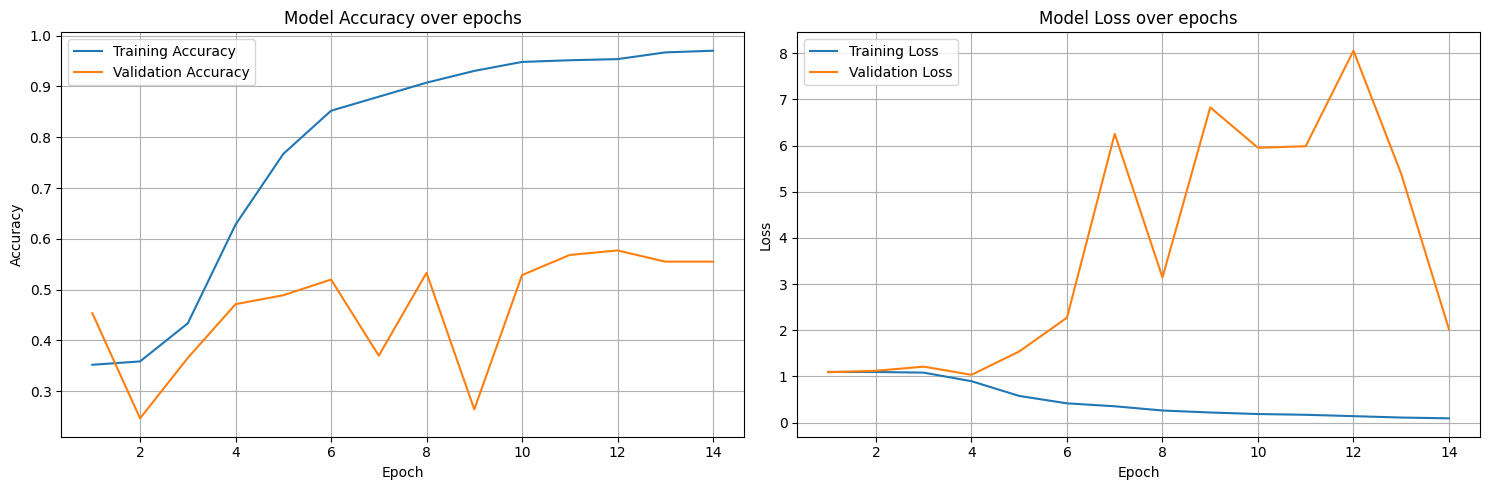

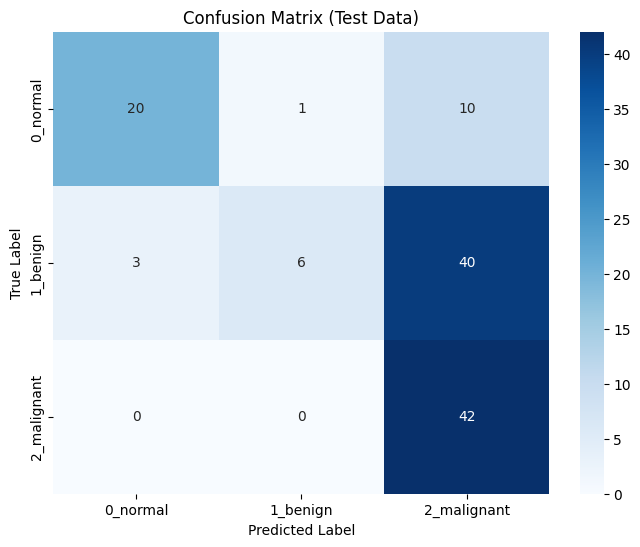


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam3.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "efficientnet_b0"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with efficientnet_b0 backbone


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 38.7MB/s]


Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.1001, Acc: 0.3488 | Val Loss: 1.0907, Acc: 0.3524
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch 2/50 | Train Loss: 1.0968, Acc: 0.3565 | Val Loss: 1.0899, Acc: 0.3524
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch 3/50 | Train Loss: 1.0990, Acc: 0.3168 | Val Loss: 1.0896, Acc: 0.3700
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch 4/50 | Train Loss: 1.0924, Acc: 0.3731 | Val Loss: 1.0858, Acc: 0.3568
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch 5/50 | Train Loss: 1.0803, Acc: 0.3996 | Val Loss: 1.0741, Acc: 0.4141
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch 6/50 | Train Loss: 1.0118, Acc: 0.5828 | Val Loss: 1.0320, Acc: 0.4141
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch 7/50 | Train Loss: 0.8442, Acc: 0.6060 | Val Loss: 0.9584, Acc: 0.4405
Model saved to /content/drive/MyDrive/GBCUD/sbam4.pth
Epoch

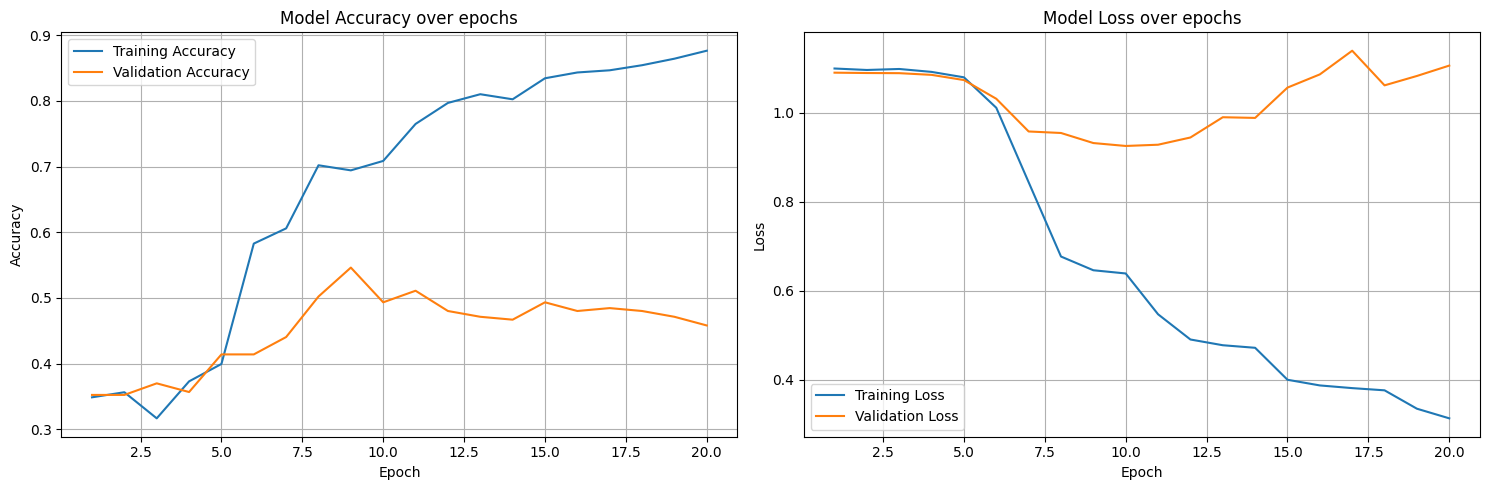

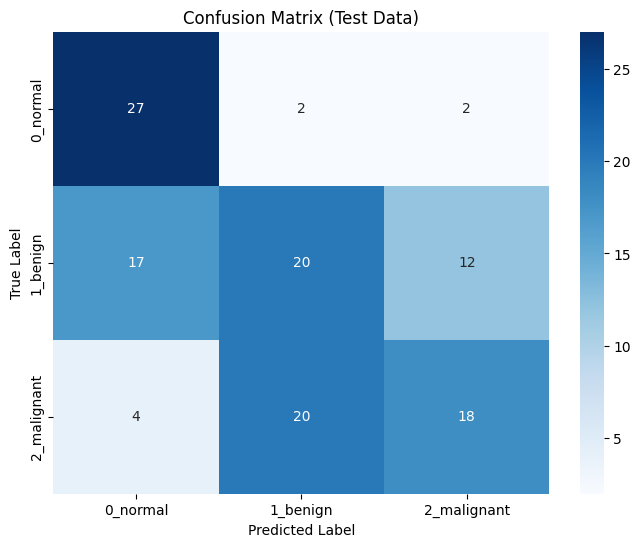


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam4.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.1MB/s]


Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0927, Acc: 0.3609 | Val Loss: 1.0296, Acc: 0.4934
Model saved to /content/drive/MyDrive/GBCUD/sbam8.pth
Epoch 2/50 | Train Loss: 0.8796, Acc: 0.5806 | Val Loss: 0.9697, Acc: 0.5154
Model saved to /content/drive/MyDrive/GBCUD/sbam8.pth
Epoch 3/50 | Train Loss: 0.6837, Acc: 0.7241 | Val Loss: 0.6251, Acc: 0.7401
Model saved to /content/drive/MyDrive/GBCUD/sbam8.pth
Epoch 4/50 | Train Loss: 0.5670, Acc: 0.7859 | Val Loss: 0.6223, Acc: 0.7533
Model saved to /content/drive/MyDrive/GBCUD/sbam8.pth
Epoch 5/50 | Train Loss: 0.5222, Acc: 0.7980 | Val Loss: 0.7108, Acc: 0.7225
Validation loss did not improve for 1 epochs :(
Epoch 6/50 | Train Loss: 0.4493, Acc: 0.8322 | Val Loss: 0.5794, Acc: 0.7577
Model saved to /content/drive/MyDrive/GBCUD/sbam8.pth
Epoch 7/50 | Train Loss: 0.4408, Acc: 0.8433 | Val Loss: 0.5747, Acc: 0.7709
Model saved to /content/drive/MyDrive/GBCUD/sbam8.pth
Epoch 8/50 

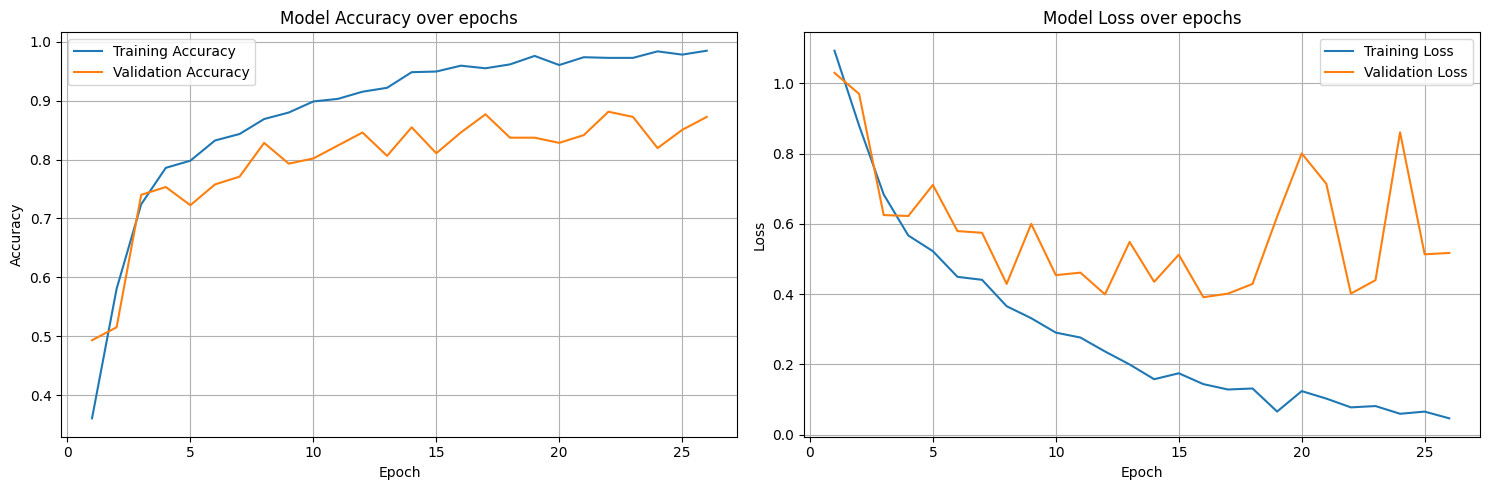

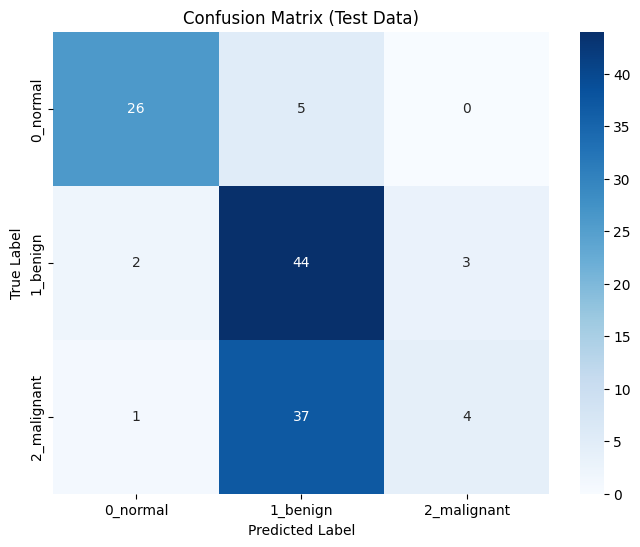


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam8.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

for 100 epochs

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/100 | Train Loss: 1.0925, Acc: 0.3653 | Val Loss: 1.0224, Acc: 0.4185
Model saved to /content/drive/MyDrive/GBCUD/sbam5.pth
Epoch 2/100 | Train Loss: 0.9159, Acc: 0.5519 | Val Loss: 0.8922, Acc: 0.5507
Model saved to /content/drive/MyDrive/GBCUD/sbam5.pth
Epoch 3/100 | Train Loss: 0.7936, Acc: 0.6258 | Val Loss: 0.7741, Acc: 0.5727
Model saved to /content/drive/MyDrive/GBCUD/sbam5.pth
Epoch 4/100 | Train Loss: 0.6650, Acc: 0.7241 | Val Loss: 0.6631, Acc: 0.7401
Model saved to /content/drive/MyDrive/GBCUD/sbam5.pth
Epoch 5/100 | Train Loss: 0.5181, Acc: 0.7980 | Val Loss: 0.5229, Acc: 0.7621
Model saved to /content/drive/MyDrive/GBCUD/sbam5.pth
Epoch 6/100 | Train Loss: 0.5258, Acc: 0.7892 | Val Los

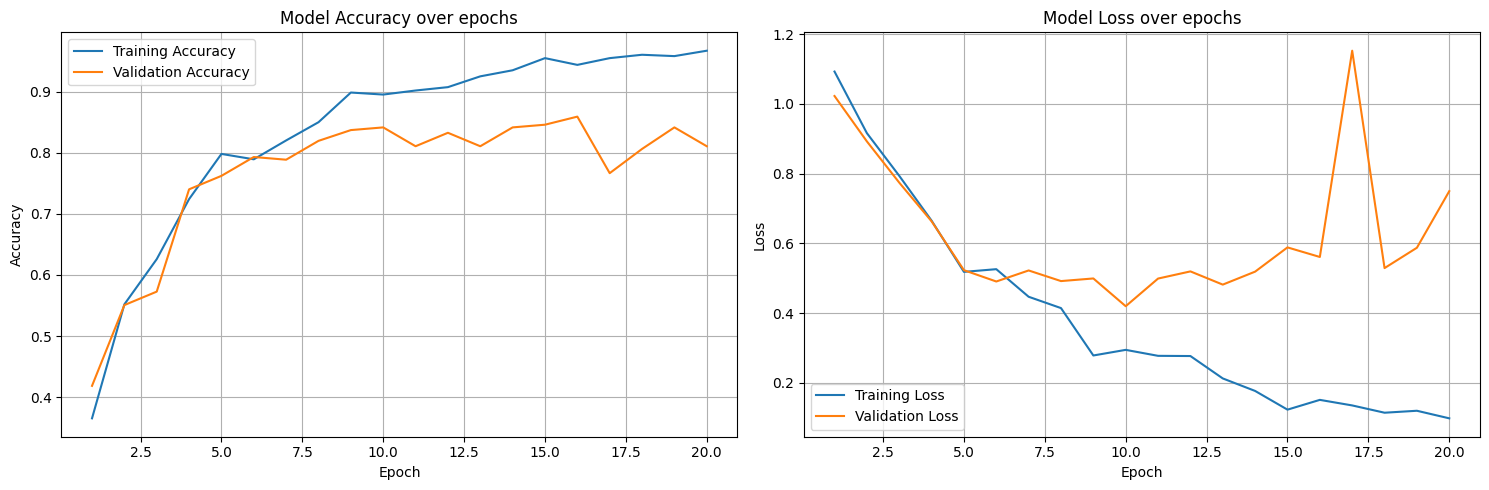

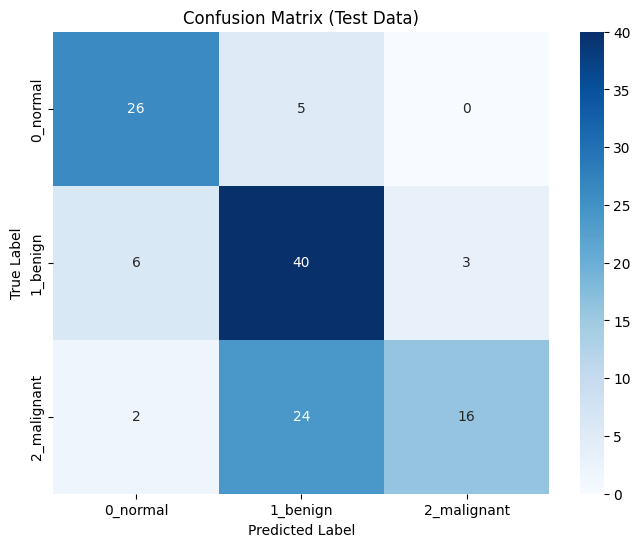


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam5.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

for 40 epochs

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/100 | Train Loss: 1.0679, Acc: 0.4007 | Val Loss: 0.9264, Acc: 0.4670
Model saved to /content/drive/MyDrive/GBCUD/sbam6.pth
Epoch 2/100 | Train Loss: 0.8156, Acc: 0.5927 | Val Loss: 0.7546, Acc: 0.7048
Model saved to /content/drive/MyDrive/GBCUD/sbam6.pth
Epoch 3/100 | Train Loss: 0.6801, Acc: 0.6821 | Val Loss: 0.7204, Acc: 0.6784
Model saved to /content/drive/MyDrive/GBCUD/sbam6.pth
Epoch 4/100 | Train Loss: 0.5671, Acc: 0.7737 | Val Loss: 0.7316, Acc: 0.7093
Validation loss did not improve for 1 epochs :(
Epoch 5/100 | Train Loss: 0.5100, Acc: 0.7958 | Val Loss: 0.6601, Acc: 0.7445
Model saved to /content/drive/MyDrive/GBCUD/sbam6.pth
Epoch 6/100 | Train Loss: 0.4332, Acc: 0.8333 | Val Loss: 0.6

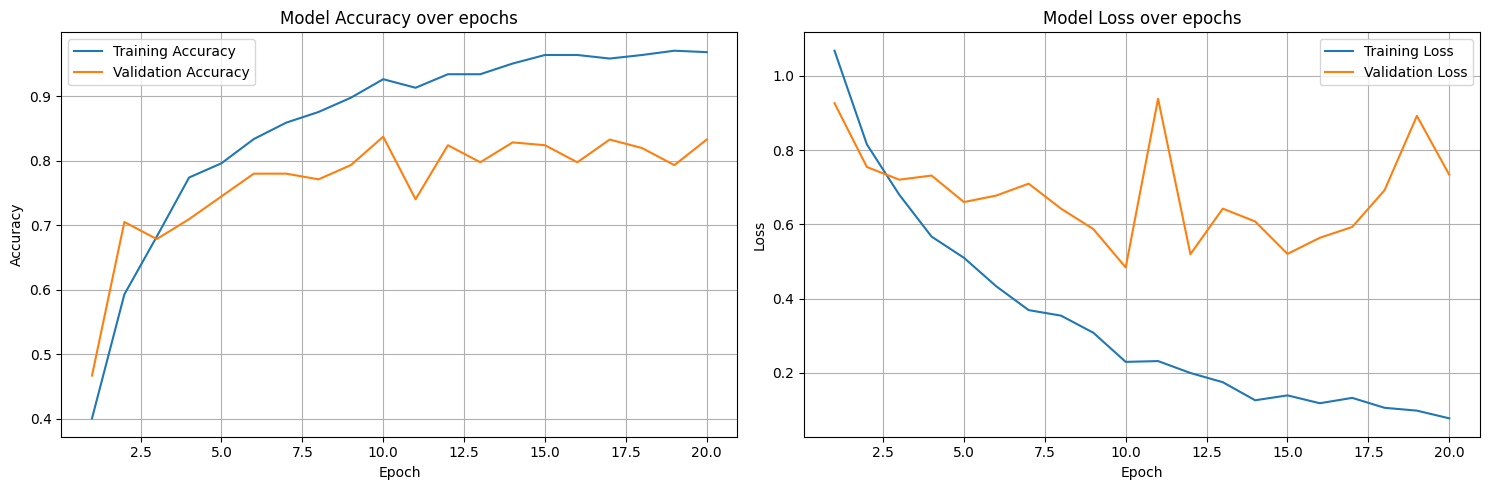

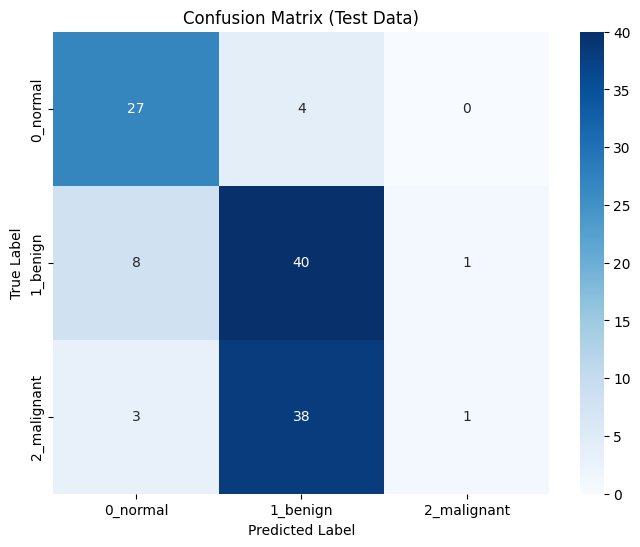


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam6.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

# Final

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0834, Acc: 0.3687 | Val Loss: 1.0803, Acc: 0.3789
Model saved to /content/drive/MyDrive/GBCUD/sbam7.pth
Epoch 2/50 | Train Loss: 0.9170, Acc: 0.5386 | Val Loss: 1.1733, Acc: 0.4185
Validation loss did not improve for 1 epochs :(
Epoch 3/50 | Train Loss: 0.8224, Acc: 0.6115 | Val Loss: 0.7668, Acc: 0.6344
Model saved to /content/drive/MyDrive/GBCUD/sbam7.pth
Epoch 4/50 | Train Loss: 0.7110, Acc: 0.6766 | Val Loss: 0.8042, Acc: 0.6123
Validation loss did not improve for 1 epochs :(
Epoch 5/50 | Train Loss: 0.6017, Acc: 0.7461 | Val Loss: 0.6219, Acc: 0.7181
Model saved to /content/drive/MyDrive/GBCUD/sbam7.pth
Epoch 6/50 | Train Loss: 0.5039, Acc: 0.8013 | Val Loss: 0.6444, Acc: 0.

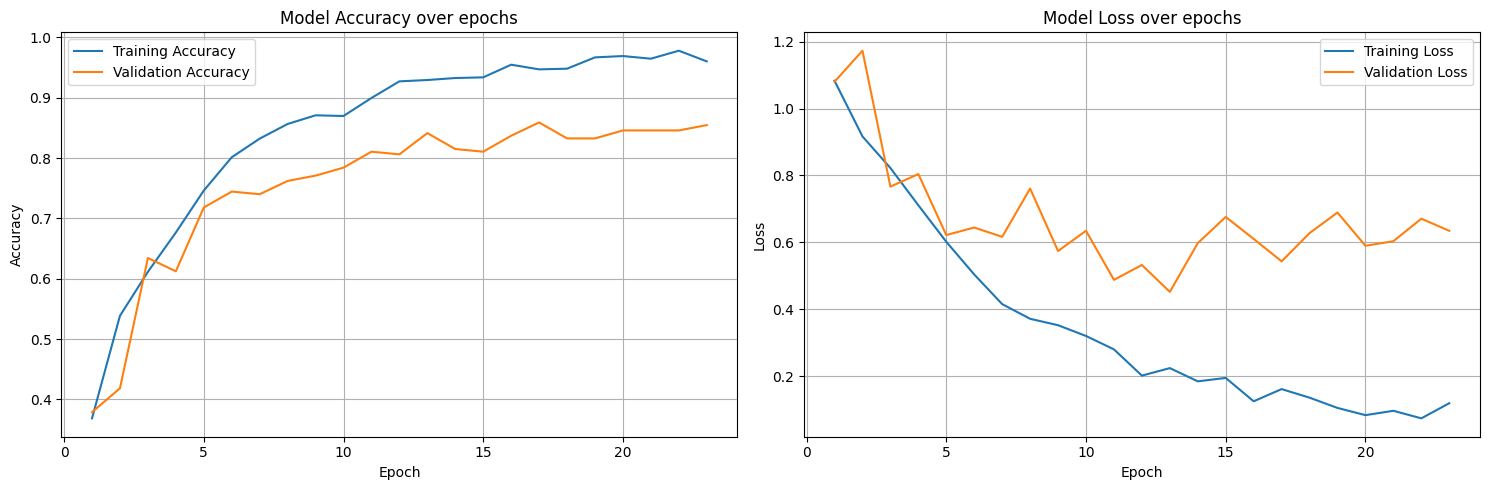

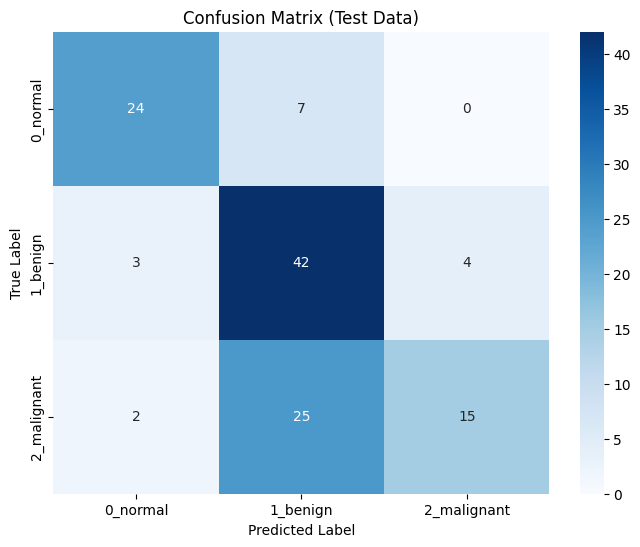


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam7.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
CLASS_WEIGHTS = [0.6, 0.4, 6.0]

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.6, 0.4, 6.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0676, Acc: 0.4139 | Val Loss: 0.9036, Acc: 0.4802
Model saved to /content/drive/MyDrive/GBCUD/sbam9.pth
Epoch 2/50 | Train Loss: 0.8218, Acc: 0.6104 | Val Loss: 0.7905, Acc: 0.5903
Model saved to /content/drive/MyDrive/GBCUD/sbam9.pth
Epoch 3/50 | Train Loss: 0.6953, Acc: 0.6755 | Val Loss: 0.7212, Acc: 0.6476
Model saved to /content/drive/MyDrive/GBCUD/sbam9.pth
Epoch 4/50 | Train Loss: 0.5716, Acc: 0.7550 | Val Loss: 0.6891, Acc: 0.6784
Model saved to /content/drive/MyDrive/GBCUD/sbam9.pth
Epoch 5/50 | Train Loss: 0.5098, Acc: 0.7947 | Val Loss: 0.6123, Acc: 0.7533
Model saved to /content/drive/MyDrive/GBCUD/sbam9.pth
Epoch 6/50 | Train Loss: 0.4617, Acc: 0.8223 | Val Loss: 0.5

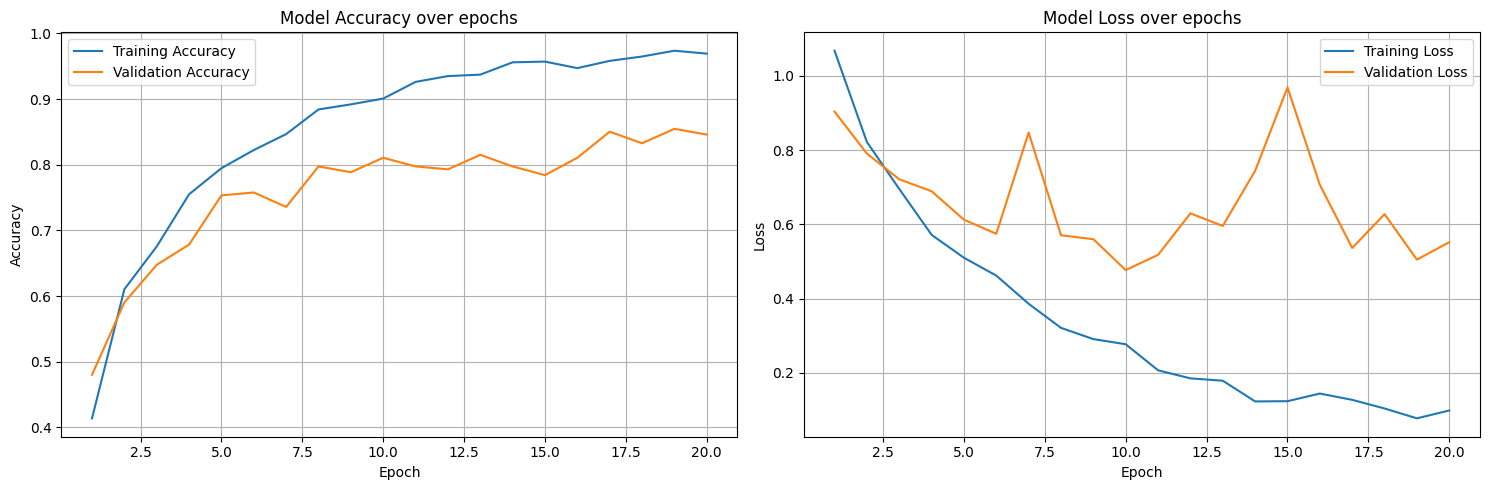

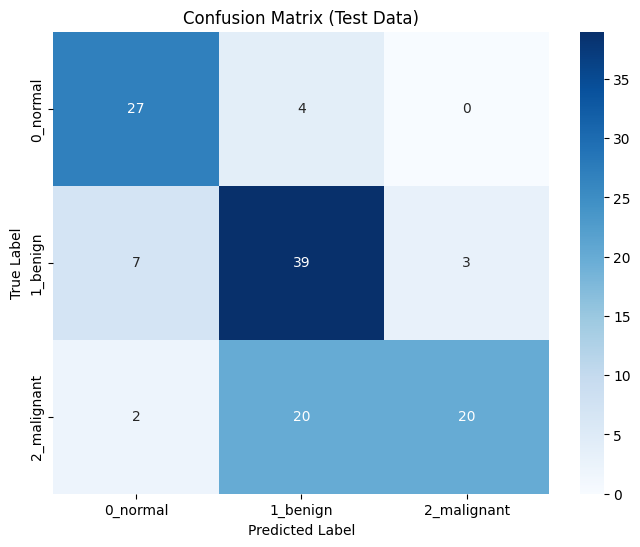


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam9.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
CLASS_WEIGHTS = [0.6, 0.4, 6.0]

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.6, 0.4, 6.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0915, Acc: 0.3731 | Val Loss: 1.1263, Acc: 0.2247
Model saved to /content/drive/MyDrive/GBCUD/sbam10.pth
Epoch 2/50 | Train Loss: 0.9326, Acc: 0.5077 | Val Loss: 0.9355, Acc: 0.5110
Model saved to /content/drive/MyDrive/GBCUD/sbam10.pth
Epoch 3/50 | Train Loss: 0.7907, Acc: 0.6137 | Val Loss: 0.8196, Acc: 0.5903
Model saved to /content/drive/MyDrive/GBCUD/sbam10.pth
Epoch 4/50 | Train Loss: 0.6728, Acc: 0.7152 | Val Loss: 0.8986, Acc: 0.5727
Validation loss did not improve for 1 epochs :(
Epoch 5/50 | Train Loss: 0.6376, Acc: 0.7428 | Val Loss: 0.6009, Acc: 0.7841
Model saved to /content/drive/MyDrive/GBCUD/sbam10.pth
Epoch 6/50 | Train Loss: 0.5101, Acc: 0.7804 | Val Loss: 0.813

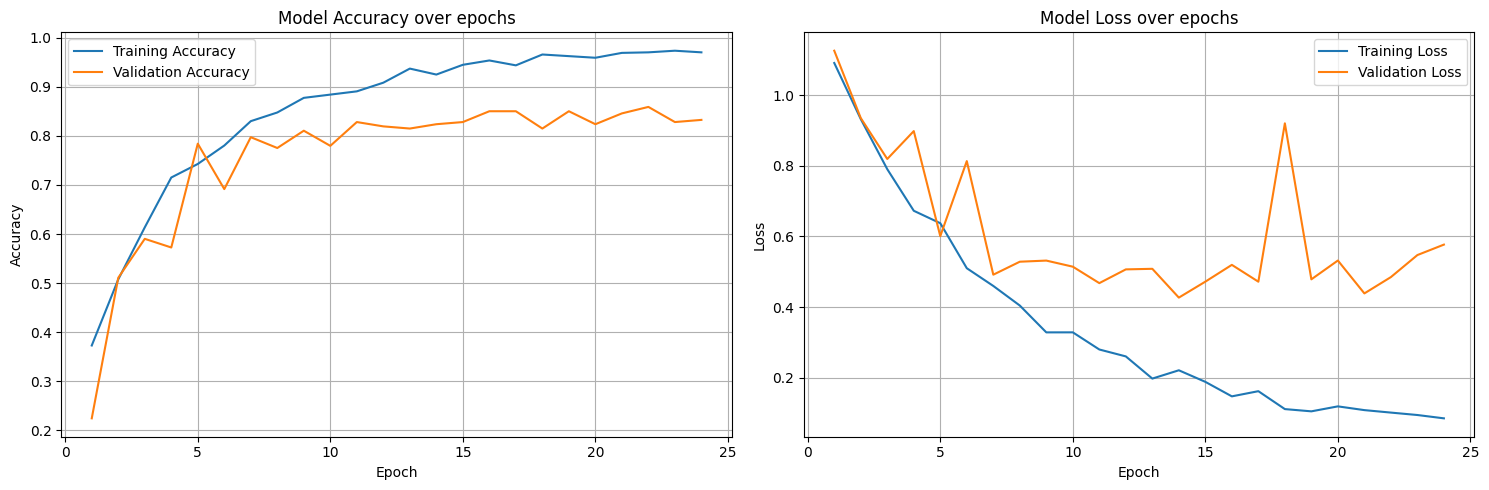

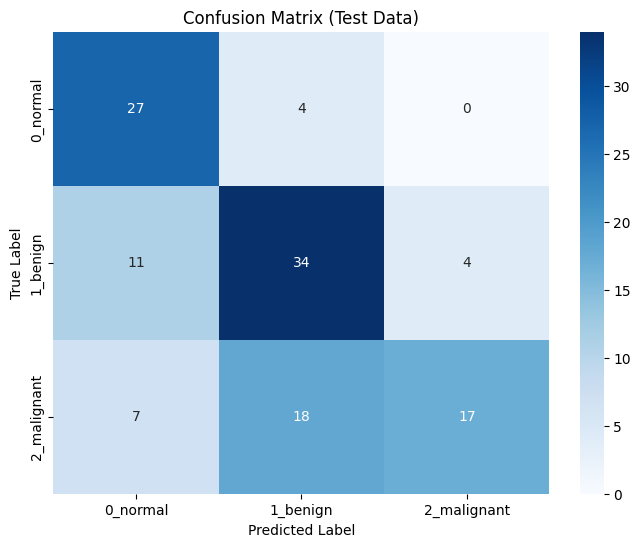


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam10.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
CLASS_WEIGHTS = [0.8, 0.6, 3.0]

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0959, Acc: 0.3620 | Val Loss: 1.1059, Acc: 0.2863
Model saved to /content/drive/MyDrive/GBCUD/sbam11.pth
Epoch 2/50 | Train Loss: 0.8385, Acc: 0.6247 | Val Loss: 0.7937, Acc: 0.6432
Model saved to /content/drive/MyDrive/GBCUD/sbam11.pth
Epoch 3/50 | Train Loss: 0.6681, Acc: 0.7031 | Val Loss: 0.8249, Acc: 0.6476
Validation loss did not improve for 1 epochs :(
Epoch 4/50 | Train Loss: 0.5669, Acc: 0.7837 | Val Loss: 0.7872, Acc: 0.6828
Model saved to /content/drive/MyDrive/GBCUD/sbam11.pth
Epoch 5/50 | Train Loss: 0.4892, Acc: 0.8046 | Val Loss: 0.5853, Acc: 0.7533
Model saved to /content/drive/MyDrive/GBCUD/sbam11.pth
Epoch 6/50 | Train Loss: 0.3865, Acc: 0.8477 | Val Loss: 0.526

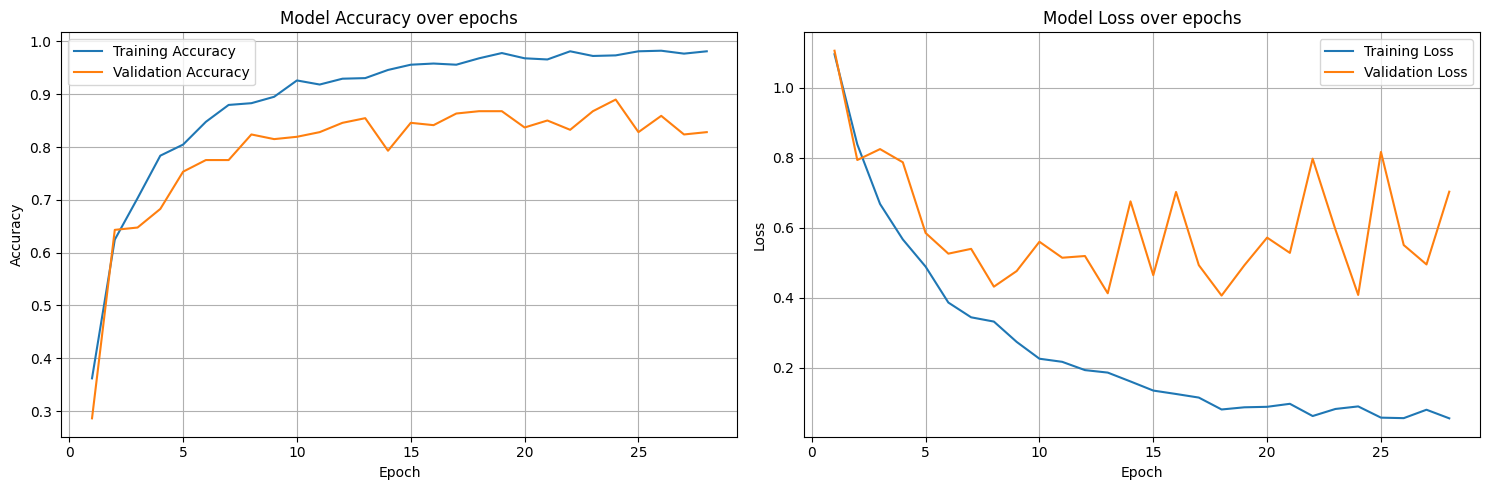

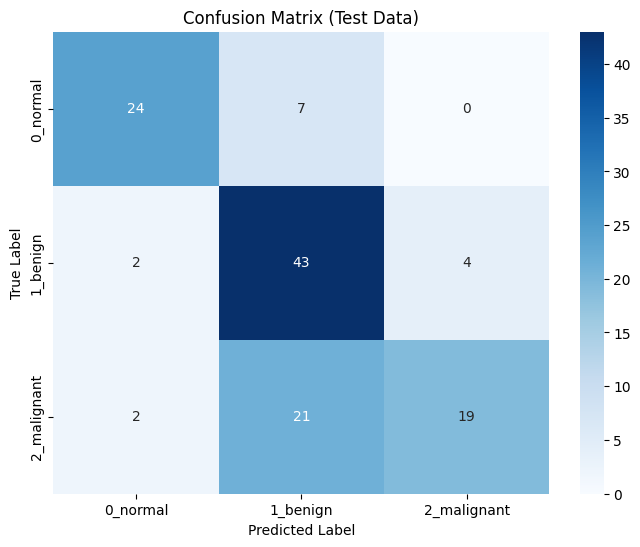


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam11.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Loading the datasets
Train dataset: 1133 images.
Test dataset: 122 images.
Splitting train data
Training subset size: 906
Validation subset size: 227
DataLoaders
Model with vgg16 backbone
Using CrossEntropyLoss with the weights: [0.8, 0.6, 3.0]
Start Training model
Epoch 1/50 | Train Loss: 1.0776, Acc: 0.3742 | Val Loss: 1.2219, Acc: 0.2423
Model saved to /content/drive/MyDrive/GBCUD/sbam12.pth
Epoch 2/50 | Train Loss: 0.8554, Acc: 0.5872 | Val Loss: 0.8074, Acc: 0.6388
Model saved to /content/drive/MyDrive/GBCUD/sbam12.pth
Epoch 3/50 | Train Loss: 0.6801, Acc: 0.6998 | Val Loss: 0.7209, Acc: 0.7004
Model saved to /content/drive/MyDrive/GBCUD/sbam12.pth
Epoch 4/50 | Train Loss: 0.5880, Acc: 0.7892 | Val Loss: 0.6350, Acc: 0.7445
Model saved to /content/drive/MyDrive/GBCUD/sbam12.pth
Epoch 5/50 | Train Loss: 0.4579, Acc: 0.8355 | Val Loss: 0.5725, Acc: 0.7533
Model saved to /content/drive/MyDrive/GBCUD/sbam12.pth
Epoch 6/50 | Train Loss: 0.4088, Acc: 0.8444 | Val Loss

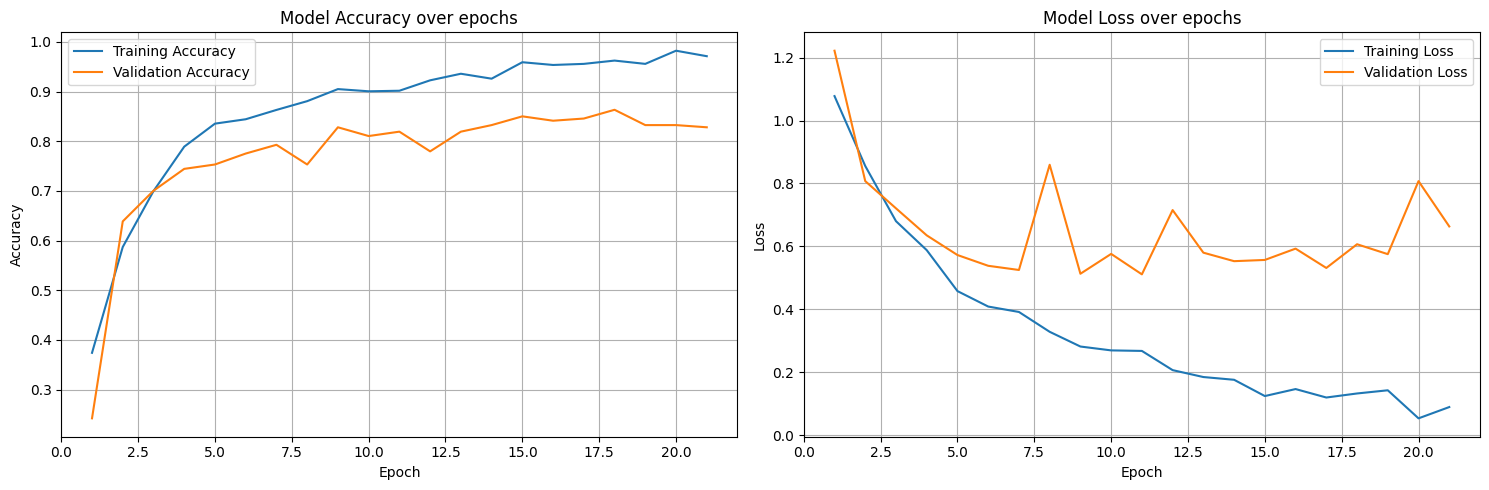

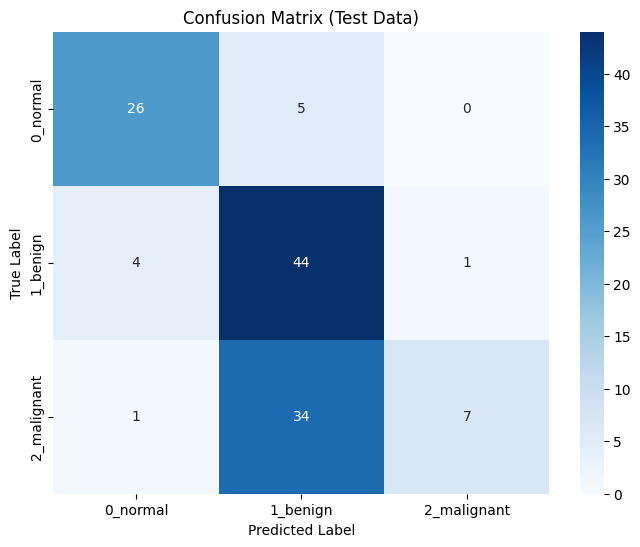


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE)

    print("Loading the datasets")

    full_train_dataset = ImageBagDataset(
        image_dir=TRAIN_IMGS_PATH,
        transform=train_transforms
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms
    )

    print(f"Train dataset: {len(full_train_dataset)} images.")
    print(f"Test dataset: {len(test_dataset)} images.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.labels

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("DataLoaders")
    num_workers = 2

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(
        num_classes=NUM_CLASSES,
        backbone_name=BACKBONE_NAME,
        pretrained=PRETRAINED,
        dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with the weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='sbam12.pth',
        patience=PATIENCE
    )

    # Evaluat on Test Set
    print("\nEvaluating on test set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"AUC: {test_metrics['auc']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")